# Load Libraries

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn import base
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score
from statsmodels.stats.weightstats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn import tree
import statsmodels.api as sm
from statsmodels.formula.api import ols
import xgboost as xgb
import optuna

# Read Data

In [102]:
data = pd.read_csv('../Data/train.csv')

# Split Data

In [103]:
train, test = train_test_split(data,random_state=4,test_size=0.15)

# Understand Data 1

In [89]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16351 entries, 7985 to 17530
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                16351 non-null  int64  
 1   Price             16351 non-null  int64  
 2   Levy              16351 non-null  object 
 3   Manufacturer      16351 non-null  object 
 4   Model             16351 non-null  object 
 5   Prod. year        16351 non-null  int64  
 6   Category          16351 non-null  object 
 7   Leather interior  16351 non-null  object 
 8   Fuel type         16351 non-null  object 
 9   Engine volume     16351 non-null  object 
 10  Mileage           16351 non-null  object 
 11  Cylinders         16351 non-null  float64
 12  Gear box type     16351 non-null  object 
 13  Drive wheels      16351 non-null  object 
 14  Doors             16351 non-null  object 
 15  Wheel             16351 non-null  object 
 16  Color             16351 non-null  obj

### Check the target variable

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


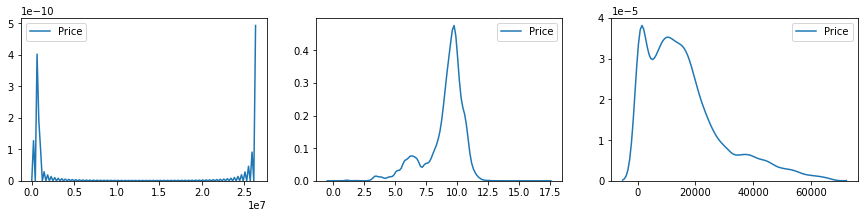

In [117]:
#keep data between higher and lower bracket
lower_b = np.percentile(train["Price"], 3)
higher_b = np.percentile(train["Price"], 98)

data_kept = train[(train["Price"]>lower_b) & (train['Price']<higher_b)]

# compare data with data kept
fig, ax =plt.subplots(1,3, figsize=(15,3))
sns.kdeplot(train["Price"],ax=ax[0])
sns.kdeplot(np.log(train["Price"]),ax=ax[1])
sns.kdeplot(data_kept["Price"],ax=ax[2])
fig.show()

### Visualize Numerical Columns

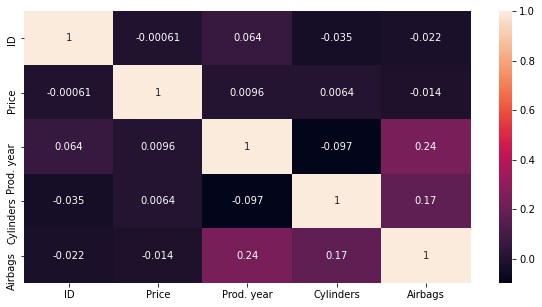

In [60]:
plt.figure(figsize=(10,5))
sns.heatmap(train.corr(), annot=True)
plt.show()

**Observation**

- we can see a very less correlation numbers we are having with the numerical columns
- the lowest is the ID so we can remove the same

### Visualize categorical columns

In [61]:
categorical_cols = train.select_dtypes(include=np.object).columns.tolist()
categorical_cols

['Levy',
 'Manufacturer',
 'Model',
 'Category',
 'Leather interior',
 'Fuel type',
 'Engine volume',
 'Mileage',
 'Gear box type',
 'Drive wheels',
 'Doors',
 'Wheel',
 'Color']

#### Get unique values of each columns

In [62]:
data_length = pd.DataFrame({'Col_name':[], 'Length':[]})
c_name = []
u_length = []
for i in categorical_cols:
    c_name.append(i)
    u_length.append(len(train[i].unique()))

data_length['Col_name'] = c_name
data_length['Length'] = u_length

data_length

,Col_name,Length
0,Levy,526
1,Manufacturer,64
2,Model,1435
3,Category,11
4,Leather interior,2
5,Fuel type,7
6,Engine volume,107
7,Mileage,6801
8,Gear box type,4
9,Drive wheels,3


#### Watch categorical variables and see what primary preprocessing can be done

In [104]:
train['Levy'].value_counts()

-       4910
765      420
891      384
640      349
639      337
        ... 
2874       1
1991       1
461        1
873        1
1466       1
Name: Levy, Length: 526, dtype: int64

In [116]:
# as we can see there is a significance differnec in volume
len(data['Model'].unique()), len(data['Model'].apply(handle_model).unique())

(1590, 1511)

## Preprocessing

In [115]:
# remove turbo in engine volume
def handle_engine_volume(ele):
    val =  float(str(ele).split(" ")[0])
    return val if val!=np.nan else 0

# convert levy into integer and impute '-' with 0
def handle_levy(x):
    if x=='-':
        return 0
    else:
        return float(x)

# get the mileage values in numerical
def handle_mileage(x):
    return float(x.split(" ")[0])

# models consists of mistakes where some modes are writtena n higher in lower letters
def handle_model(x):
    return x.lower()

train['Model'] = train['Model'].apply(handle_model)

train["Levy"] = train["Levy"].apply(handle_levy)
train["Engine volume"] = train["Engine volume"].apply(handle_engine_volume)
train["Mileage"] = train["Mileage"].apply(handle_mileage)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [92]:
# Dropping  4% data as we observed that makes data sort of bell curve
lower_b = np.percentile(train["Price"], 3)
higher_b = np.percentile(train["Price"], 98)

train_outliers = train[(train["Price"]<=lower_b) | (train['Price']>=higher_b)]
train = train[(train["Price"]>lower_b) & (train['Price']<higher_b)]

In [93]:
# DROP ID
train = train.drop(["ID"], axis=1)

# get the numeric dtype columns for standardization
numeric_cols = train.select_dtypes(include=np.number).columns.tolist()
numeric_cols = [x for x in numeric_cols if x!="Price"]

#get categorical columns for encoding
cat_cols = [x for x in train.columns if x not in numeric_cols and x!="Price"]


print(numeric_cols)
print(cat_cols)

['Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags']
['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color']


In [94]:
# Handle Categorical Features
label_encoders = {}
for col_name in cat_cols:
    encoder = LabelEncoder()
    encoder.fit(train[col_name])
    label_encoders[col_name] = encoder


# Handle Numerical Features
scalers= {}
for col_name in numeric_cols:
    scaler = StandardScaler()
    scaler.fit(train[col_name].values.reshape(-1,1))
    scalers[col_name] = scaler

# encode categorical variables
for col in cat_cols:
    train[col] = label_encoders[col].transform(train[col])

# scale numerical variables
for col in numeric_cols:
    train[col] = scalers[col].transform(train[col].values.reshape(-1, 1)).squeeze()

X = train.drop("Price", axis=1)
# y = np.log(df_train["Price"])
y = train["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=4)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(13146, 16)
(13146,)
(2321, 16)
(2321,)


In [67]:
scalers

{'Levy': StandardScaler(),
 'Prod. year': StandardScaler(),
 'Engine volume': StandardScaler(),
 'Mileage': StandardScaler(),
 'Cylinders': StandardScaler(),
 'Airbags': StandardScaler()}

In [68]:
X_train

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
14294,-0.526713,55,989,0.916189,3,1,2,-0.923643,-0.022188,-0.474253,0,1,1,0,1,1.260755
42,0.025072,58,763,0.916189,9,1,5,-1.039865,-0.029359,-0.474253,2,1,1,0,1,0.329374
12293,-1.150864,55,431,-0.688767,9,0,5,-1.039865,-0.024330,-0.474253,1,1,1,0,1,-0.136317
12172,0.003363,27,924,0.559532,9,1,5,-0.342534,-0.028496,-0.474253,0,1,1,0,1,-0.602008
3497,0.006981,53,1114,0.381203,9,1,5,-0.342534,-0.024770,-0.474253,0,1,1,0,11,-1.533389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12299,-1.150864,15,1213,-0.153782,6,0,5,0.819684,-0.024984,1.244816,2,2,1,1,6,1.027910
6742,0.690833,34,844,0.024547,4,1,1,0.819684,-0.029641,1.244816,0,0,1,0,1,1.260755
3282,-0.090712,55,989,0.202875,3,1,2,-0.574977,-0.019272,-0.474253,0,1,1,0,2,1.260755
17998,-1.150864,4,125,-1.937066,9,1,5,0.238575,-0.029213,1.244816,1,2,1,1,6,-0.602008


### Functions for scoring models with log and without log

In [95]:
# function to get scoring and mse of test and train
def print_scores(model, log_used=False):
    if log_used:
        print("RMSE on Train Data: ", mean_squared_error(y_train, np.exp(model.predict(X_train)),squared=False))
        print("RMSE on Test Data: ", mean_squared_error(y_test, np.exp(model.predict(X_test)),squared=False))

        print("R2 on Train Data: ",  r2_score(y_train, np.exp(model.predict(X_train))))
        print("R2 on Test Data: ",  r2_score(y_test, np.exp(model.predict(X_test))))
    else:
        print("RMSE on Train Data: ", mean_squared_error(y_train, model.predict(X_train),squared=False))
        print("RMSE on Test Data: ", mean_squared_error(y_test, model.predict(X_test),squared=False))

        print("R2 on Train Data: ",  r2_score(y_train,model.predict(X_train)))
        print("R2 on Test Data: ",  r2_score(y_test, model.predict(X_test)))


In [96]:
# function to get scoring and mse of test and train
def print_scores_valid(model, log_used=False):
    if log_used:
        print("RMSE on Test Data: ", mean_squared_error(y_test, np.exp(model.predict(X_test)),squared=False))
        print("RMSE on valid Data: ", mean_squared_error(y_valid, np.exp(model.predict(X_valid)),squared=False))

        print("R2 on Test Data: ",  r2_score(y_test, np.exp(model.predict(X_test))))
        print("R2 on valid Data: ",  r2_score(y_valid, np.exp(model.predict(X_valid))))
    else:
        print("RMSE on Test Data: ", mean_squared_error(y_test, model.predict(X_test),squared=False))
        print("RMSE on valid Data: ", mean_squared_error(y_valid, model.predict(X_valid),squared=False))

        print("R2 on Test Data: ",  r2_score(y_test,model.predict(X_test)))
        print("R2 on valid Data: ",  r2_score(y_valid, model.predict(X_valid)))


## Modeling

#### Linear Regression

In [71]:
lr_model = LinearRegression().fit(X_train, y_train)

print_scores(lr_model)

RMSE on Train Data:  11944.940308836121
RMSE on Test Data:  11982.10408464993
R2 on Train Data:  0.20967111723389698
R2 on Test Data:  0.2342024608839527


#### Ridge

In [72]:
ridge_model = Ridge().fit(X_train, y_train)

print_scores(ridge_model)
# print_scores(ridge_model, log_used=True)

RMSE on Train Data:  11944.940421242647
RMSE on Test Data:  11982.142215819955
R2 on Train Data:  0.20967110235929376
R2 on Test Data:  0.2341975868146864


#### Decision Tree

In [73]:

dt_model = tree.DecisionTreeRegressor(max_depth=10).fit(X_train, y_train)

print_scores(dt_model)
# print_scores(dt_model, log_used=True)

RMSE on Train Data:  6175.116309877798
RMSE on Test Data:  7772.374895238154
R2 on Train Data:  0.7887823676567588
R2 on Test Data:  0.6777779388338324


#### Random Forest

In [97]:
rf = RandomForestRegressor(max_depth=50,n_estimators=500).fit(X_train, y_train)

print_scores(rf)

RMSE on Train Data:  2598.8303643579698
RMSE on Test Data:  6089.311278887588
R2 on Train Data:  0.9625893072177062
R2 on Test Data:  0.8022191945138168


#### Important Features

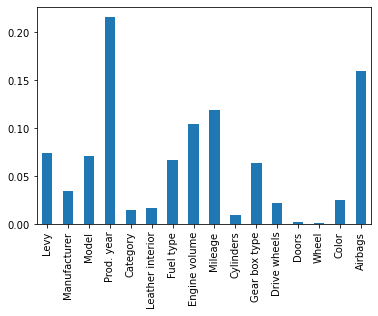

In [48]:
cols = list(X_train.columns)
pd.Series(rf.feature_importances_, index=cols).plot.bar()

In [100]:
import shap
# build an Exact explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Exact(rf.predict, X_test)
shap_values = explainer(X_train[:100])


Exact explainer:  78%|███████▊  | 78/100 [5:10:49<1:25:46, 233.93s/it]

KeyboardInterrupt: 

In [ ]:
shap.summary_plot(shap_values, X_test)

## Inference Pipeline

In [98]:
def inference_pipeline(train,label_encoders, scalers):
    def handle_engine_volume(ele):
        val =  float(str(ele).split(" ")[0])
        return val if val!=np.nan else 0

    def handle_levy(x):
        if x=='-':
            return 0
        else:
            return float(x)

    def handle_mileage(x):
        return float(x.split(" ")[0])
    
    def handle_model(x):
        return x.lower()

    if 'ID' in train.columns: 
        train = train.drop(["ID"], axis=1)
        
    
    train["Levy"] = train["Levy"].apply(handle_levy)
    train['Model'] = train['Model'].apply(handle_model)
    train["Engine volume"] = train["Engine volume"].apply(handle_engine_volume)
    train["Mileage"] = train["Mileage"].apply(handle_mileage)
    
    numeric_cols = train.select_dtypes(include=np.number).columns.tolist()
    numeric_cols = [x for x in numeric_cols if x!="Price"]
    cat_cols = [x for x in train.columns if x not in numeric_cols and x!="Price"]

    print(numeric_cols)
    print(cat_cols)
    
    for i in cat_cols:
        if '<unknown>' not in label_encoders[i].classes_ :
            train[i] = train[i].map(lambda s: '<unknown>' if s not in label_encoders[i].classes_ else s)
            label_encoders[i].classes_ = np.append(label_encoders[i].classes_, '<unknown>')
        else:
            train[i] = train[i].map(lambda s: '<unknown>' if s not in label_encoders[i].classes_ else s)
    
    for col in cat_cols:
        train[col] = label_encoders[col].transform(train[col])

    for col in numeric_cols:
        train[col] = scalers[col].transform(train[col].values.reshape(-1, 1)).squeeze()
                                      
    return train

#### Score with Alien Data 

In [99]:
valid = pd.read_csv('../Data/test_data.csv').iloc[:,1:]
valid = inference_pipeline(valid, label_encoders, scalers)
X_valid = valid.drop('Price', axis=1)
y_valid = valid['Price']

print_scores_valid(rf)

['Levy', 'Prod. year', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags']
['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color']
RMSE on Test Data:  6089.311278887588
RMSE on valid Data:  8843.452620190335
R2 on Test Data:  0.8022191945138168
R2 on valid Data:  0.7139973505654017


In [336]:
scalers

{'Levy': StandardScaler(),
 'Prod. year': StandardScaler(),
 'Engine volume': StandardScaler(),
 'Mileage': StandardScaler(),
 'Cylinders': StandardScaler(),
 'Airbags': StandardScaler()}

In [368]:
with open('Model.pkl', 'wb') as f:
    p = pickle.Pickler(f)
    p.fast = True
    p.dump(rf)

In [338]:
with open('encoder.pkl', 'wb') as f:
    p = pickle.Pickler(f)
    p.fast = True
    p.dump(label_encoders)

with open('scalar.pkl', 'wb') as f:
    p = pickle.Pickler(f)
    p.fast = True
    p.dump(scalers)

## Model Hyper-parameter tuning

In [124]:
# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.
    rf_max_depth = trial.suggest_int('rf_max_depth', 10, 50, log=False)
    estim = trial.suggest_int('estim', 100, 500, log=False)

    obj = RandomForestRegressor(max_depth=rf_max_depth, n_estimators=estim)
    score = cross_val_score(obj, X_train, y_train , n_jobs=-1, cv=4)
    score_test = cross_val_score(obj, X_test, y_test , n_jobs=-1, cv=4)
    accuracy = score.mean()   
    accuracy1 = score_test.mean() 
    print(accuracy)
    return accuracy1


# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)
study.best_trial

[I 2022-07-15 02:06:29,060] A new study created in memory with name: no-name-b13cfe53-c1d4-4fb2-9b0d-2e088359e572
[I 2022-07-15 02:07:06,315] Trial 0 finished with value: 0.6921144624453226 and parameters: {'rf_max_depth': 24, 'estim': 312}. Best is trial 0 with value: 0.6921144624453226.


0.7752295232628507


[I 2022-07-15 02:07:28,642] Trial 1 finished with value: 0.6875336053561754 and parameters: {'rf_max_depth': 13, 'estim': 251}. Best is trial 0 with value: 0.6921144624453226.


0.7615857033198297


[I 2022-07-15 02:07:40,441] Trial 2 finished with value: 0.6898059133415573 and parameters: {'rf_max_depth': 29, 'estim': 103}. Best is trial 0 with value: 0.6921144624453226.


0.7730023949444313


[I 2022-07-15 02:08:09,896] Trial 3 finished with value: 0.6910338214525911 and parameters: {'rf_max_depth': 30, 'estim': 261}. Best is trial 0 with value: 0.6921144624453226.


0.7751100181592773


[I 2022-07-15 02:08:44,344] Trial 4 finished with value: 0.6906825288376329 and parameters: {'rf_max_depth': 23, 'estim': 304}. Best is trial 0 with value: 0.6921144624453226.


0.7758012909614971


[I 2022-07-15 02:09:28,494] Trial 5 finished with value: 0.6919533761862051 and parameters: {'rf_max_depth': 32, 'estim': 392}. Best is trial 0 with value: 0.6921144624453226.


0.7747739093455348


[I 2022-07-15 02:10:19,094] Trial 6 finished with value: 0.6900037763141642 and parameters: {'rf_max_depth': 21, 'estim': 425}. Best is trial 0 with value: 0.6921144624453226.


0.7743584600565702


[I 2022-07-15 02:10:34,392] Trial 7 finished with value: 0.6905940132943602 and parameters: {'rf_max_depth': 49, 'estim': 129}. Best is trial 0 with value: 0.6921144624453226.


0.773749283507615


[I 2022-07-15 02:11:07,102] Trial 8 finished with value: 0.6902140375719952 and parameters: {'rf_max_depth': 36, 'estim': 289}. Best is trial 0 with value: 0.6921144624453226.


0.7751683203029205


[I 2022-07-15 02:11:43,480] Trial 9 finished with value: 0.6921089963220112 and parameters: {'rf_max_depth': 22, 'estim': 329}. Best is trial 0 with value: 0.6921144624453226.


0.7753609440279075


[I 2022-07-15 02:12:18,617] Trial 10 finished with value: 0.6801943737231178 and parameters: {'rf_max_depth': 10, 'estim': 498}. Best is trial 0 with value: 0.6921144624453226.


0.7256637909151498


[I 2022-07-15 02:12:58,124] Trial 11 finished with value: 0.6910076284455182 and parameters: {'rf_max_depth': 20, 'estim': 362}. Best is trial 0 with value: 0.6921144624453226.


0.7745941444122206


[I 2022-07-15 02:13:22,816] Trial 12 finished with value: 0.6899300027051598 and parameters: {'rf_max_depth': 39, 'estim': 215}. Best is trial 0 with value: 0.6921144624453226.


0.7747456976027205


[I 2022-07-15 02:13:55,824] Trial 13 finished with value: 0.6905702447058129 and parameters: {'rf_max_depth': 15, 'estim': 342}. Best is trial 0 with value: 0.6921144624453226.


0.76929560275077


[I 2022-07-15 02:14:16,159] Trial 14 finished with value: 0.6898216150177561 and parameters: {'rf_max_depth': 25, 'estim': 180}. Best is trial 0 with value: 0.6921144624453226.


0.7746415801748439


[I 2022-07-15 02:15:04,810] Trial 15 finished with value: 0.6913650510731841 and parameters: {'rf_max_depth': 40, 'estim': 432}. Best is trial 0 with value: 0.6921144624453226.


0.7757024878604697


[I 2022-07-15 02:15:39,836] Trial 16 finished with value: 0.6893678172479502 and parameters: {'rf_max_depth': 19, 'estim': 327}. Best is trial 0 with value: 0.6921144624453226.


0.7741225934361151


[I 2022-07-15 02:16:22,749] Trial 17 finished with value: 0.6926403166452864 and parameters: {'rf_max_depth': 27, 'estim': 380}. Best is trial 17 with value: 0.6926403166452864.


0.7749118519696053


[I 2022-07-15 02:17:13,816] Trial 18 finished with value: 0.6914625661463759 and parameters: {'rf_max_depth': 27, 'estim': 451}. Best is trial 17 with value: 0.6926403166452864.


0.7746235357706888


[I 2022-07-15 02:17:56,428] Trial 19 finished with value: 0.6928204440242665 and parameters: {'rf_max_depth': 34, 'estim': 380}. Best is trial 19 with value: 0.6928204440242665.


0.7746882089099847


[I 2022-07-15 02:18:39,667] Trial 20 finished with value: 0.6914755332625433 and parameters: {'rf_max_depth': 47, 'estim': 382}. Best is trial 19 with value: 0.6928204440242665.


0.7753836372351962


[I 2022-07-15 02:19:25,535] Trial 21 finished with value: 0.6924380198071545 and parameters: {'rf_max_depth': 33, 'estim': 406}. Best is trial 19 with value: 0.6928204440242665.


0.7750456591487472


[I 2022-07-15 02:20:19,648] Trial 22 finished with value: 0.691446919822921 and parameters: {'rf_max_depth': 35, 'estim': 482}. Best is trial 19 with value: 0.6928204440242665.


0.7757391628775454


[I 2022-07-15 02:21:04,688] Trial 23 finished with value: 0.6932228613119665 and parameters: {'rf_max_depth': 43, 'estim': 399}. Best is trial 23 with value: 0.6932228613119665.


0.7744556685857124


[I 2022-07-15 02:21:45,639] Trial 24 finished with value: 0.6900054694317115 and parameters: {'rf_max_depth': 44, 'estim': 364}. Best is trial 23 with value: 0.6932228613119665.


0.7747025543223919


[I 2022-07-15 02:22:38,474] Trial 25 finished with value: 0.6932191774641319 and parameters: {'rf_max_depth': 42, 'estim': 459}. Best is trial 23 with value: 0.6932228613119665.


0.7755161328889323


[I 2022-07-15 02:23:30,402] Trial 26 finished with value: 0.6924078273092089 and parameters: {'rf_max_depth': 42, 'estim': 461}. Best is trial 23 with value: 0.6932228613119665.


0.7749993083711315


[I 2022-07-15 02:24:16,586] Trial 27 finished with value: 0.6920457785809535 and parameters: {'rf_max_depth': 45, 'estim': 411}. Best is trial 23 with value: 0.6932228613119665.


0.7755857537300206


[I 2022-07-15 02:25:08,164] Trial 28 finished with value: 0.6910644215707118 and parameters: {'rf_max_depth': 39, 'estim': 457}. Best is trial 23 with value: 0.6932228613119665.


0.7746339687012551


[I 2022-07-15 02:25:57,042] Trial 29 finished with value: 0.6908397463242666 and parameters: {'rf_max_depth': 36, 'estim': 437}. Best is trial 23 with value: 0.6932228613119665.


0.7756032507925309


[I 2022-07-15 02:26:52,401] Trial 30 finished with value: 0.6926843259740514 and parameters: {'rf_max_depth': 42, 'estim': 486}. Best is trial 23 with value: 0.6932228613119665.


0.7756168063252038


[I 2022-07-15 02:27:46,507] Trial 31 finished with value: 0.6911018850238531 and parameters: {'rf_max_depth': 42, 'estim': 478}. Best is trial 23 with value: 0.6932228613119665.


0.7752663532430565


[I 2022-07-15 02:28:42,258] Trial 32 finished with value: 0.6917277237643664 and parameters: {'rf_max_depth': 50, 'estim': 496}. Best is trial 23 with value: 0.6932228613119665.


0.7750532547828468


[I 2022-07-15 02:29:35,461] Trial 33 finished with value: 0.6904457662482604 and parameters: {'rf_max_depth': 46, 'estim': 470}. Best is trial 23 with value: 0.6932228613119665.


0.7747357542189452


[I 2022-07-15 02:30:21,912] Trial 34 finished with value: 0.6912385419440044 and parameters: {'rf_max_depth': 42, 'estim': 413}. Best is trial 23 with value: 0.6932228613119665.


0.7757165661793624


[I 2022-07-15 02:31:12,722] Trial 35 finished with value: 0.6898341739218653 and parameters: {'rf_max_depth': 37, 'estim': 443}. Best is trial 23 with value: 0.6932228613119665.


0.7755361982025695


[I 2022-07-15 02:31:52,567] Trial 36 finished with value: 0.6927700730015653 and parameters: {'rf_max_depth': 33, 'estim': 355}. Best is trial 23 with value: 0.6932228613119665.


0.7747146784631858


[I 2022-07-15 02:32:24,189] Trial 37 finished with value: 0.6934246668311409 and parameters: {'rf_max_depth': 32, 'estim': 276}. Best is trial 37 with value: 0.6934246668311409.


0.7739106062090796


[I 2022-07-15 02:32:55,665] Trial 38 finished with value: 0.6913501757650584 and parameters: {'rf_max_depth': 30, 'estim': 280}. Best is trial 37 with value: 0.6934246668311409.


0.7752711535206263


[I 2022-07-15 02:33:23,464] Trial 39 finished with value: 0.6911601556343419 and parameters: {'rf_max_depth': 31, 'estim': 239}. Best is trial 37 with value: 0.6934246668311409.


0.7742444653827361


[I 2022-07-15 02:33:58,299] Trial 40 finished with value: 0.6912690232784857 and parameters: {'rf_max_depth': 34, 'estim': 309}. Best is trial 37 with value: 0.6934246668311409.


0.7752649198567748


[I 2022-07-15 02:34:38,348] Trial 41 finished with value: 0.6926722804534403 and parameters: {'rf_max_depth': 38, 'estim': 356}. Best is trial 37 with value: 0.6934246668311409.


0.7753232827953737


[I 2022-07-15 02:35:08,814] Trial 42 finished with value: 0.6917363626158346 and parameters: {'rf_max_depth': 32, 'estim': 272}. Best is trial 37 with value: 0.6934246668311409.


0.7753129373358052


[I 2022-07-15 02:35:55,208] Trial 43 finished with value: 0.6930280520361308 and parameters: {'rf_max_depth': 29, 'estim': 399}. Best is trial 37 with value: 0.6934246668311409.


0.775310982735617


[I 2022-07-15 02:36:40,011] Trial 44 finished with value: 0.6906114223956097 and parameters: {'rf_max_depth': 28, 'estim': 395}. Best is trial 37 with value: 0.6934246668311409.


0.7741660681637619


[I 2022-07-15 02:37:07,484] Trial 45 finished with value: 0.6927944551005615 and parameters: {'rf_max_depth': 48, 'estim': 244}. Best is trial 37 with value: 0.6934246668311409.


0.7745439083404123


[I 2022-07-15 02:37:55,401] Trial 46 finished with value: 0.692012082389279 and parameters: {'rf_max_depth': 25, 'estim': 422}. Best is trial 37 with value: 0.6934246668311409.


0.7750936900043335


[I 2022-07-15 02:38:15,785] Trial 47 finished with value: 0.6901991282159075 and parameters: {'rf_max_depth': 29, 'estim': 180}. Best is trial 37 with value: 0.6934246668311409.


0.7749357574282363


[I 2022-07-15 02:38:53,811] Trial 48 finished with value: 0.6917136245110228 and parameters: {'rf_max_depth': 40, 'estim': 336}. Best is trial 37 with value: 0.6934246668311409.


0.7751964322737623


[I 2022-07-15 02:39:27,206] Trial 49 finished with value: 0.6909647721460462 and parameters: {'rf_max_depth': 35, 'estim': 295}. Best is trial 37 with value: 0.6934246668311409.


0.7743285877067274


[I 2022-07-15 02:40:09,291] Trial 50 finished with value: 0.6901514996198962 and parameters: {'rf_max_depth': 23, 'estim': 377}. Best is trial 37 with value: 0.6934246668311409.


0.7752102039839062


[I 2022-07-15 02:40:36,876] Trial 51 finished with value: 0.6903730049969853 and parameters: {'rf_max_depth': 47, 'estim': 244}. Best is trial 37 with value: 0.6934246668311409.


0.7745337326392254


[I 2022-07-15 02:41:01,939] Trial 52 finished with value: 0.6898681681975801 and parameters: {'rf_max_depth': 48, 'estim': 223}. Best is trial 37 with value: 0.6934246668311409.


0.7750128626743238


[I 2022-07-15 02:41:31,652] Trial 53 finished with value: 0.6915437918972251 and parameters: {'rf_max_depth': 44, 'estim': 263}. Best is trial 37 with value: 0.6934246668311409.


0.7743533483691037


[I 2022-07-15 02:41:53,216] Trial 54 finished with value: 0.6905209879927945 and parameters: {'rf_max_depth': 50, 'estim': 191}. Best is trial 37 with value: 0.6934246668311409.


0.7752087570293501


[I 2022-07-15 02:42:34,026] Trial 55 finished with value: 0.6927074756250559 and parameters: {'rf_max_depth': 17, 'estim': 396}. Best is trial 37 with value: 0.6934246668311409.


0.7727769755599713


[I 2022-07-15 02:43:09,776] Trial 56 finished with value: 0.689958352259981 and parameters: {'rf_max_depth': 44, 'estim': 318}. Best is trial 37 with value: 0.6934246668311409.


0.7756555552152786


[I 2022-07-15 02:43:24,781] Trial 57 finished with value: 0.6902951007233656 and parameters: {'rf_max_depth': 26, 'estim': 133}. Best is trial 37 with value: 0.6934246668311409.


0.7744553829179883


[I 2022-07-15 02:43:50,591] Trial 58 finished with value: 0.6884108515369585 and parameters: {'rf_max_depth': 40, 'estim': 227}. Best is trial 37 with value: 0.6934246668311409.


0.7752956430001154


[I 2022-07-15 02:44:19,237] Trial 59 finished with value: 0.6901955358058988 and parameters: {'rf_max_depth': 30, 'estim': 253}. Best is trial 37 with value: 0.6934246668311409.


0.7745191610091615


[I 2022-07-15 02:45:01,503] Trial 60 finished with value: 0.6905636826545665 and parameters: {'rf_max_depth': 48, 'estim': 375}. Best is trial 37 with value: 0.6934246668311409.


0.7752859216106888


[I 2022-07-15 02:45:40,410] Trial 61 finished with value: 0.6883430793371383 and parameters: {'rf_max_depth': 33, 'estim': 340}. Best is trial 37 with value: 0.6934246668311409.


0.7746974585148003


[I 2022-07-15 02:46:19,578] Trial 62 finished with value: 0.6911761258438847 and parameters: {'rf_max_depth': 32, 'estim': 348}. Best is trial 37 with value: 0.6934246668311409.


0.7743124044680547


[I 2022-07-15 02:47:07,530] Trial 63 finished with value: 0.6932865599868302 and parameters: {'rf_max_depth': 37, 'estim': 424}. Best is trial 37 with value: 0.6934246668311409.


0.7756311207075632


[I 2022-07-15 02:47:56,414] Trial 64 finished with value: 0.6908334079852587 and parameters: {'rf_max_depth': 37, 'estim': 426}. Best is trial 37 with value: 0.6934246668311409.


0.7753672799464328


[I 2022-07-15 02:48:46,663] Trial 65 finished with value: 0.6940260916913282 and parameters: {'rf_max_depth': 35, 'estim': 438}. Best is trial 65 with value: 0.6940260916913282.


0.7749568022076573


[I 2022-07-15 02:49:37,274] Trial 66 finished with value: 0.6921603107965763 and parameters: {'rf_max_depth': 35, 'estim': 443}. Best is trial 65 with value: 0.6940260916913282.


0.7744074195337063


[I 2022-07-15 02:50:29,720] Trial 67 finished with value: 0.6922774254483539 and parameters: {'rf_max_depth': 37, 'estim': 462}. Best is trial 65 with value: 0.6940260916913282.


0.7757075614441388


[I 2022-07-15 02:51:15,698] Trial 68 finished with value: 0.6940257037130491 and parameters: {'rf_max_depth': 41, 'estim': 408}. Best is trial 65 with value: 0.6940260916913282.


0.775890333933009


[I 2022-07-15 02:52:01,000] Trial 69 finished with value: 0.6922527375117212 and parameters: {'rf_max_depth': 41, 'estim': 402}. Best is trial 65 with value: 0.6940260916913282.


0.7746712496586803


FrozenTrial(number=65, values=[0.6940260916913282], datetime_start=datetime.datetime(2022, 7, 15, 2, 47, 56, 415091), datetime_complete=datetime.datetime(2022, 7, 15, 2, 48, 46, 663240), params={'rf_max_depth': 35, 'estim': 438}, distributions={'rf_max_depth': IntUniformDistribution(high=50, low=10, step=1), 'estim': IntUniformDistribution(high=500, low=100, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=65, state=TrialState.COMPLETE, value=None)

In [120]:
# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 10, 50, log=False)
    estim = trial.suggest_int('estim', 100, 500, log=False)

    obj = xgb.XGBRegressor(max_depth=xgb_max_depth, n_estimators=estim, alpha = alpha_val, normalize_type = 'forest')
    score = cross_val_score(obj, X_train, y_train , n_jobs=-1, cv=4) #njobs=-1 means using all processors
    score_test = cross_val_score(obj, X_test, y_test , n_jobs=-1, cv=4)
    accuracy = score.mean()    
    accuracy1 = score_test.mean()
    print(accuracy) 
    return accuracy1

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
study.best_trial

[I 2022-07-15 01:32:43,376] A new study created in memory with name: no-name-32c0c196-d213-4ff3-ba5d-188344fa0245
[I 2022-07-15 01:33:27,144] Trial 0 finished with value: 0.6341812100205457 and parameters: {'xgb_max_depth': 33, 'estim': 210, 'alpha_val': 0.010694523448541663, 'normalize_type1': 'forest'}. Best is trial 0 with value: 0.6341812100205457.


0.7523189689366281


[I 2022-07-15 01:33:58,777] Trial 1 finished with value: 0.6320815090907362 and parameters: {'xgb_max_depth': 24, 'estim': 175, 'alpha_val': 0.01488506883366893, 'normalize_type1': 'tree'}. Best is trial 0 with value: 0.6341812100205457.


0.7522123962276351


[I 2022-07-15 01:34:03,366] Trial 2 finished with value: 0.6766511523170452 and parameters: {'xgb_max_depth': 6, 'estim': 109, 'alpha_val': 0.011952180421221762, 'normalize_type1': 'tree'}. Best is trial 2 with value: 0.6766511523170452.


0.7677412607557927


[I 2022-07-15 01:34:39,643] Trial 3 finished with value: 0.6412267852435609 and parameters: {'xgb_max_depth': 15, 'estim': 354, 'alpha_val': 0.043862530571444826, 'normalize_type1': 'tree'}. Best is trial 2 with value: 0.6766511523170452.


0.7509335841548354


[I 2022-07-15 01:34:46,032] Trial 4 finished with value: 0.6135906931702234 and parameters: {'xgb_max_depth': 2, 'estim': 331, 'alpha_val': 0.07238375213072426, 'normalize_type1': 'forest'}. Best is trial 2 with value: 0.6766511523170452.


0.6566536510141612


[I 2022-07-15 01:34:54,989] Trial 5 finished with value: 0.6638701474515387 and parameters: {'xgb_max_depth': 5, 'estim': 258, 'alpha_val': 0.0961572093104113, 'normalize_type1': 'tree'}. Best is trial 2 with value: 0.6766511523170452.


0.761578202219329


[I 2022-07-15 01:35:22,714] Trial 6 finished with value: 0.6361728967559388 and parameters: {'xgb_max_depth': 20, 'estim': 179, 'alpha_val': 0.03710780026296234, 'normalize_type1': 'forest'}. Best is trial 2 with value: 0.6766511523170452.


0.7501091872362677


[I 2022-07-15 01:35:48,084] Trial 7 finished with value: 0.6374687969117867 and parameters: {'xgb_max_depth': 17, 'estim': 203, 'alpha_val': 0.010030369998796442, 'normalize_type1': 'forest'}. Best is trial 2 with value: 0.6766511523170452.


0.7497293367668085


[I 2022-07-15 01:35:55,518] Trial 8 finished with value: 0.615907114804635 and parameters: {'xgb_max_depth': 2, 'estim': 384, 'alpha_val': 0.055229469660948514, 'normalize_type1': 'tree'}. Best is trial 2 with value: 0.6766511523170452.


0.6628014374824875


[I 2022-07-15 01:36:10,065] Trial 9 finished with value: 0.6411553034460328 and parameters: {'xgb_max_depth': 15, 'estim': 131, 'alpha_val': 0.013288762491033813, 'normalize_type1': 'forest'}. Best is trial 2 with value: 0.6766511523170452.


0.751117870228233


[I 2022-07-15 01:36:14,603] Trial 10 finished with value: 0.6770515518233237 and parameters: {'xgb_max_depth': 6, 'estim': 103, 'alpha_val': 0.02205337398561987, 'normalize_type1': 'tree'}. Best is trial 10 with value: 0.6770515518233237.


0.7666263848932178


[I 2022-07-15 01:36:19,153] Trial 11 finished with value: 0.6770515515055144 and parameters: {'xgb_max_depth': 6, 'estim': 103, 'alpha_val': 0.02260817831871234, 'normalize_type1': 'tree'}. Best is trial 10 with value: 0.6770515518233237.


0.7666263845986551


[I 2022-07-15 01:36:22,479] Trial 12 finished with value: 0.6639710754317258 and parameters: {'xgb_max_depth': 4, 'estim': 106, 'alpha_val': 0.025241717616174858, 'normalize_type1': 'tree'}. Best is trial 10 with value: 0.6770515518233237.


0.7248849803383113


[I 2022-07-15 01:36:31,741] Trial 13 finished with value: 0.6575431446252686 and parameters: {'xgb_max_depth': 9, 'estim': 143, 'alpha_val': 0.022671418998557596, 'normalize_type1': 'tree'}. Best is trial 10 with value: 0.6770515518233237.


0.7659665022046716


[I 2022-07-15 01:36:40,472] Trial 14 finished with value: 0.6575338230428929 and parameters: {'xgb_max_depth': 9, 'estim': 138, 'alpha_val': 0.019731524959423385, 'normalize_type1': 'tree'}. Best is trial 10 with value: 0.6770515518233237.


0.7659667886234378


[I 2022-07-15 01:36:43,211] Trial 15 finished with value: 0.6428778643200126 and parameters: {'xgb_max_depth': 3, 'estim': 105, 'alpha_val': 0.02829420106829238, 'normalize_type1': 'tree'}. Best is trial 10 with value: 0.6770515518233237.


0.6796329711744615


[I 2022-07-15 01:36:56,388] Trial 16 finished with value: 0.6678746995881779 and parameters: {'xgb_max_depth': 7, 'estim': 283, 'alpha_val': 0.017296609137651523, 'normalize_type1': 'tree'}. Best is trial 10 with value: 0.6770515518233237.


0.7673976061946567


[I 2022-07-15 01:37:00,288] Trial 17 finished with value: 0.6499740280601733 and parameters: {'xgb_max_depth': 3, 'estim': 157, 'alpha_val': 0.03621384271153831, 'normalize_type1': 'tree'}. Best is trial 10 with value: 0.6770515518233237.


0.6979672016047953


[I 2022-07-15 01:37:33,782] Trial 18 finished with value: 0.6426883178083895 and parameters: {'xgb_max_depth': 11, 'estim': 441, 'alpha_val': 0.01860909117664212, 'normalize_type1': 'tree'}. Best is trial 10 with value: 0.6770515518233237.


0.7625629456687731


[I 2022-07-15 01:37:37,466] Trial 19 finished with value: 0.6633418672438393 and parameters: {'xgb_max_depth': 4, 'estim': 121, 'alpha_val': 0.030140776312542073, 'normalize_type1': 'tree'}. Best is trial 10 with value: 0.6770515518233237.


0.7304486220270806


#### Stacking goodness of catplot and random forest

In [114]:
estimators = [('xgb', xgb.XGBRegressor(max_depth=4, n_estimators=121)),
              ('rand', RandomForestRegressor(max_depth=50,n_estimators=500))]

reg_stack = StackingRegressor(estimators=estimators)
reg_stack.fit(X_train, y_train)

print_scores(reg_stack)
print_scores_valid(reg_stack)

0:	learn: 9459.1161527	total: 260ms	remaining: 2.34s
1:	learn: 7783.0697111	total: 463ms	remaining: 1.85s
2:	learn: 7031.0425044	total: 664ms	remaining: 1.55s
3:	learn: 6616.6606133	total: 867ms	remaining: 1.3s
4:	learn: 6115.6196876	total: 1.08s	remaining: 1.08s
5:	learn: 5903.8366593	total: 1.29s	remaining: 861ms
6:	learn: 5632.2842376	total: 1.5s	remaining: 644ms
7:	learn: 5354.6624063	total: 1.71s	remaining: 429ms
8:	learn: 5237.1698844	total: 1.92s	remaining: 213ms
9:	learn: 5095.7408095	total: 2.13s	remaining: 0us
0:	learn: 9535.6003248	total: 250ms	remaining: 2.25s
1:	learn: 7937.3866203	total: 442ms	remaining: 1.77s
2:	learn: 7082.7413267	total: 655ms	remaining: 1.53s
3:	learn: 6449.2117427	total: 853ms	remaining: 1.28s
4:	learn: 6137.7710404	total: 1.06s	remaining: 1.06s
5:	learn: 5764.7941401	total: 1.25s	remaining: 834ms
6:	learn: 5589.8132786	total: 1.45s	remaining: 621ms
7:	learn: 5469.0195604	total: 1.64s	remaining: 411ms
8:	learn: 5181.3003483	total: 1.85s	remaining: 206

## Feature testing

In [144]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15467 entries, 7985 to 17530
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             15467 non-null  int64  
 1   Levy              15467 non-null  float64
 2   Manufacturer      15467 non-null  int64  
 3   Model             15467 non-null  int64  
 4   Prod. year        15467 non-null  float64
 5   Category          15467 non-null  int64  
 6   Leather interior  15467 non-null  int64  
 7   Fuel type         15467 non-null  int64  
 8   Engine volume     15467 non-null  float64
 9   Mileage           15467 non-null  float64
 10  Cylinders         15467 non-null  float64
 11  Gear box type     15467 non-null  int64  
 12  Drive wheels      15467 non-null  int64  
 13  Doors             15467 non-null  int64  
 14  Wheel             15467 non-null  int64  
 15  Color             15467 non-null  int64  
 16  Airbags           15467 non-null  flo

### Taking sample from data and checking their mean difference as big statistical models dont accept larger poplulation

In [118]:
sample = train.sample(800)

In [119]:
val = train['Price'].mean()

In [120]:
from statsmodels.stats.weightstats import ztest

_, p_val = ztest(train['Price'],x2 = sample['Price'])

if p_val < 0.05:
    print('The two groups are different, failed to reject null hypothesis testing')
else:
    print('The two groups are equal, accepting hypothesis testing')
print(p_val)

The two groups are equal, accepting hypothesis testing
0.8071690625614285


In [20]:
sample.to_csv('../Data.Sample.csv', index=False)

#### Testing if Leather Interior values showcases any difference

In [ ]:
sample = pd.read_csv('Data.Sample.csv')

In [21]:
train_stat = data.rename(columns={'Leather interior':'LeatherInterior'})

In [22]:
from statsmodels.stats.weightstats import ztest

_, p_val = ztest(train_stat[train_stat['LeatherInterior'] == 'No']['Price'],x2 = train_stat[train_stat['LeatherInterior'] == 'Yes']['Price'], alternative = 'two-sided')

if p_val < 0.05:
    print('The two groups are different, failed to reject null hypothesis testing')
else:
    print('The two groups are equal, accepting hypothesis testing')

The two groups are equal, accepting hypothesis testing


#### Impact of Features on Price
- df = degree of freedom: n_categories-1
- F = variation between sample means
- PR(>F) = P-values
- H0: There is no difference in mean
- H1: There is difference in mean

In [200]:
## joining column names with length 2 or more as anova doesnot accept column names with length 2 or more
for i in sample.columns:
    if len(i)>1:
        sample.rename(columns={i:''.join(i.split())}, inplace=True)

In [203]:
sample.columns

Index(['Price', 'Levy', 'Manufacturer', 'Model', 'Prod.year', 'Category',
       'LeatherInterior', 'Fueltype', 'Enginevolume', 'Mileage', 'Cylinders',
       'Gearboxtype', 'Drivewheels', 'Doors', 'Wheel', 'Color', 'Airbags'],
      dtype='object')

## Mean Price distribution for every Categorical variables

In [204]:
sample = sample.rename(columns={'LeatherInterior':'Leatherinterior'})
method1 = ols('Price ~ C(Manufacturer)+C(Leatherinterior)+C(Category)+C(Model)+C(Fueltype)+C(Color)+C(Wheel)',
              data = sample[['Wheel','Color','Fueltype','Model',
                             'Manufacturer','Category','Leatherinterior','Price']]).fit()
ava_table = sm.stats.anova_lm(method1, typ = 2)
ava_table

,sum_sq,df,F,PR(>F)
C(Manufacturer),1.068218e+10,38.0,2.087762,2.166757e-04
C(Leatherinterior),1.221747e+09,1.0,9.073732,2.714573e-03
C(Category),2.776789e+09,10.0,2.062280,2.578983e-02
C(Model),5.567775e+10,228.0,1.813642,1.625399e-08
C(Fueltype),1.027616e+09,5.0,1.526391,1.797313e-01
C(Color),2.583212e+09,14.0,1.370367,1.626490e-01
C(Wheel),1.260612e+09,1.0,9.362376,2.324850e-03
Residual,7.270913e+10,540.0,NaN,NaN


## Get the correlation matrix for the numerical values

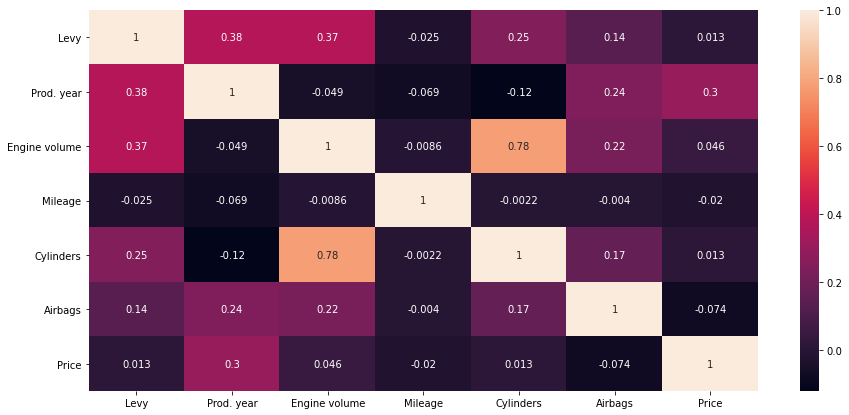

In [217]:
plt.figure(figsize=(15,7))
sns.heatmap(train[numeric_cols].corr(), annot = True)
plt.show()

**Observation**
- post hoc test in non-significant p values

In [24]:
# perform ttest for indipendent values in 
def get_indipendence(feature_name, percent):    
    cat_values = list(sample[feature_name].unique())
    n = len(cat_values)
    model_pairs = []
    for i in range(n-1):
        for j in range(i+1,n):
            if (cat_values[i],cat_values[j]) not in model_pairs or(cat_values[j],cat_values[i]) not in model_pairs:
                model_pairs.append((cat_values[i],cat_values[j]))

    mem_j = []
    similar_volumes = {}
    for i, j in model_pairs:
        t = ttest_ind(sample[sample[feature_name] == i]['Price'], sample[sample[feature_name] == j]['Price'])
        if t[1]> percent/100:
            if i not in similar_volumes:
                similar_volumes[i] = []
                if i not in mem_j and j not in mem_j:
                    mem_j.append(i)
                    similar_volumes[i] = [j]
            else:
                if j not in mem_j or i not in mem_j:
                    mem_j.append(j)
                    similar_volumes[i].append(j)
                    
    most_similar_values={}
    for i in similar_volumes:
        if len(similar_volumes[i])!=0:
            most_similar_values[i] = similar_volumes[i]
    return most_similar_values

#### Model

In [235]:
similar_volumes = get_indipendence('Model', 90)
print(f"Model with {i}% similar data",similar_volumes)

Model with 90% similar data {'31514': ['Fusion', 'Focus', '318', 'Outback', '328'], 'Camry SE': ['X5', 'Tucson', 'REXTON', 'Mazda 6', 'Sorento', 'L 200', 'Ghibli', 'Camaro', 'CLA 250', 'S 550'], 'Prius': ['Octavia', 'C-MAX', 'E 350', 'Aqua G', 'Picanto', 'Grand Vitara', 'tC', 'ISIS', 'Volt', 'C 200', 'Forester', '320 DIESEL', '4Runner', 'Accent', 'Navigator', 'ES 350', 'Versa', 'FIT fit', 'HS 250h', 'Legacy'], 'Cr-v': ['A4 B6', 'Picanto', 'C 230', 'C 200', '320 DIESEL', 'FIT Premiym', '3.20E+38', 'E 550', 'Navigator', 'HS 250h'], 'Corolla': ['FIT', 'Escape', 'Camry', 'Camry sel', 'Outlander', 'ML 350', 'C 280', 'GLA 250', 'Tiguan', 'X-Terra', 'X5 x5', 'Sonata Limited', 'Jetta se'], 'Altima': ['A4', '1000'], 'H1': ['Actyon', 'Pathfinder', 'X1', 'CC'], '500 Abarth': ['320', 'Aqua', 'Q7', 'Prius C', 'Tacoma', 'I30', 'RX 350', 'GX 470', 'Cerato'], 'Optima': ['CX-7', 'Impreza G4', 'Viano', 'Camry sel', 'A5', 'Jetta', 'Elantra limited', 'ML 55 AMG', 'Genesis', 'GLA 250', 'Tiguan', 'Fusion 20

- Model can get confused with some model names.

##### Engine VOlume

In [301]:
similar_volumes = get_indipendence('Enginevolume', 95)

In [302]:
similar_volumes 

{2.0: [1.7, 2.1, 4.7],
 2.5: [1.6, 1.7],
 1.8: [2.7, 2.9],
 1.3: [1.9, 5.9],
 1.6: [2.1, 4.7],
 2.2: [2.3],
 3.5: [3.8],
 3.7: [3.8],
 3.3: [1.9, 5.4]}

- Here we can see 95% similar engine volumes 

##### Manufacturer

In [296]:
similar_volumes = get_indipendence('Manufacturer', 90)
similar_volumes

{'TOYOTA': ['HONDA', 'AUDI'],
 'NISSAN': ['SKODA', 'SCION', 'LINCOLN'],
 'HYUNDAI': ['CADILLAC'],
 'FIAT': ['SUBARU', 'MAZDA', 'SKODA'],
 'FORD': ['MERCEDES-BENZ', 'INFINITI'],
 'SSANGYONG': ['LAND ROVER', 'GAZ'],
 'SUBARU': ['LINCOLN'],
 'BMW': ['LEXUS'],
 'CHEVROLET': ['MITSUBISHI'],
 'OPEL': ['VAZ'],
 'JEEP': ['LAND ROVER'],
 'LEXUS': ['CADILLAC'],
 'LAND ROVER': ['MASERATI']}

-  Manufacturers that match 99% of pricing mean

##### Category

In [292]:
for i in range(80,100,10):
    similar_volumes = get_indipendence('Category', i)
    print(f"Categories having {i}% similar data",similar_volumes)

Categories having 80% similar data {'Minivan': ['Coupe', 'Pickup'], 'Coupe': ['Microbus']}
Categories having 90% similar data {'Minivan': ['Coupe', 'Pickup']}


**Observation**
- as we can see there is 90% similarity between these categories we can merge them into one

##### Fuel Type

In [293]:
for i in range(20,100,10):
    similar_volumes = get_indipendence('Fueltype', i)
    print(f"at {i}% similar data",similar_volumes)

at 20% similar data {'Hybrid': ['LPG']}
at 30% similar data {'Hybrid': ['LPG']}
at 40% similar data {}
at 50% similar data {}
at 60% similar data {}
at 70% similar data {}
at 80% similar data {}
at 90% similar data {}


**Observation**
- as we can see there is only 20% similarity between values so we dont need to merge categories

#### Color

In [317]:
for i in range(50,100,10):
    similar_volumes = get_indipendence('Color', i)
    print(f"at {i}% similar data",similar_volumes)
    print()

at 50% similar data {'Yellow': ['Silver', 'White', 'Black', 'Blue', 'Carnelian red', 'Grey', 'Red', 'Beige'], 'Silver': ['Carnelian red', 'Beige', 'Pink'], 'Blue': ['Sky blue'], 'Purple': ['Green', 'Orange', 'Golden'], 'Green': ['Golden', 'Pink']}

at 60% similar data {'Yellow': ['Silver', 'White', 'Black', 'Blue', 'Carnelian red', 'Grey', 'Red', 'Beige'], 'Silver': ['Carnelian red', 'Beige'], 'Blue': ['Pink'], 'Purple': ['Green', 'Orange', 'Golden'], 'Green': ['Golden', 'Pink'], 'Red': ['Sky blue']}

at 70% similar data {'Yellow': ['Silver', 'Black', 'Blue', 'Carnelian red', 'Grey', 'Beige'], 'Silver': ['Carnelian red', 'Beige'], 'Purple': ['Green', 'Orange', 'Pink'], 'Green': ['Golden', 'Pink']}

at 80% similar data {'Yellow': ['Silver', 'Blue', 'Grey', 'Beige'], 'Silver': ['Carnelian red'], 'Purple': ['Green', 'Orange'], 'Carnelian red': ['Red'], 'Green': ['Pink'], 'Golden': ['Pink']}

at 90% similar data {'Yellow': ['Silver', 'Blue', 'Beige'], 'Purple': ['Green'], 'Green': ['Pink']

#### Cylinders

In [322]:
for i in range(50,100,10):
    similar_volumes = get_indipendence('Cylinders', i)
    print(f"at {i}% similar data",similar_volumes)
    print()

at 50% similar data {4.0: [5.0, 1.0], 6.0: [5.0], 2.0: [3.0]}

at 60% similar data {4.0: [5.0, 1.0], 6.0: [5.0], 2.0: [3.0]}

at 70% similar data {4.0: [5.0, 1.0], 6.0: [5.0]}

at 80% similar data {4.0: [5.0], 6.0: [5.0]}

at 90% similar data {4.0: [5.0]}



**Observation**
- 4.0 cylinder is having 90% similarity with cylinder 5

#### Merging color categories having similar price

In [25]:
merge_dict = get_indipendence('Color', 90)

print(merge_dict)
val_mem = []

def merge_val(x, merge_dict):
    merge_values = {}
    for key in merge_dict.items():
        if key not in val_mem:
            val_mem.append(merge_dict[key])
            for i in merge_dict['key']:
                merge_values[i] = key
    return merge_values

# new_col = sample["Color"].apply(lambda x:merge_groups(x,merge_dict))

{'White': ['Grey', 'Blue'], 'Black': ['Brown', 'Yellow'], 'Red': ['Green'], 'Beige': ['Carnelian red']}


In [332]:
new_col.value_counts()

new_color        219
Black            208
White            180
Grey              95
Red               32
Purple            18
Carnelian red     12
Brown              9
Sky blue           7
Golden             6
Yellow             6
Orange             6
Green              2
Name: Color, dtype: int64

#### Testing models after removing Leather Interior

In [129]:
X_train_mod = X_train.drop(columns=['Leather interior'])

X_test_mod = X_test.drop(columns=['Leather interior'])

X_valid_mod = X_valid.drop(columns=['Leather interior'])

y_valid = valid['Price']

rf = RandomForestRegressor(max_depth=50,n_estimators=500)
rf.fit(X_train, y_train)
print('Test data:',r2_score(y_test, rf.predict(X_test)))
print('Alien data:',r2_score(y_valid, rf.predict(X_valid)))

rf_mod = RandomForestRegressor(max_depth=50,n_estimators=500)
rf_mod.fit(X_train_mod, y_train)
print('On modified Test data:',r2_score(y_test, rf_mod.predict(X_test_mod)))
print('On modified Alien data:',r2_score(y_valid,rf_mod.predict(X_valid_mod)))

Test data: 0.8013886865934801
Alien data: 0.7144021759428978
On modified Test data: 0.7999869013196796
On modified Alien data: 0.7072305747764933


## Handle the spread of invalid values in predicton

In [132]:
rf_mod.predict(X_valid_mod).min(), rf_mod.predict(X_valid_mod).max()

(220.0, 62398.216)

## Check accuracy after removing features

In [174]:
X_train_mod = X_train
X_test_mod = X_test

# X_train_mod['New Feature'] = X_train['Levy']/X_train['Cylinders']*X_train['Airbags']
# X_test_mod['New Feature']  = X_test['Levy']/ X_test['Cylinders']*X_test['Airbags']

X_test_mod1 = X_test_mod.drop(columns=['Levy'])
X_train_mod1 = X_train_mod.drop(columns=['Levy'])

rf = RandomForestRegressor(max_depth=50,n_estimators=500)
rf.fit(X_train_mod1, y_train)
print('Test data:',r2_score(y_test, rf.predict(X_test_mod1)))

Test data: 0.804594183312868


In [173]:
X_train_mod.head()

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,New Feature
14294,345.0,55,989,2016,3,1,2,1.5,296104.0,4.0,0,1,1,0,1,12,1035.0
42,650.0,58,763,2016,9,1,5,1.4,11200.0,4.0,2,1,1,0,1,8,1300.0
12293,0.0,55,431,2007,9,0,5,1.4,211000.0,4.0,1,1,1,0,1,6,0.0
12172,638.0,27,924,2014,9,1,5,2.0,45504.0,4.0,0,1,1,0,1,4,638.0
3497,640.0,53,1114,2013,9,1,5,2.0,193504.0,4.0,0,1,1,0,11,0,0.0
